## Filter bidirectionals to remove any likely FPs or genes rather than enhancers
1. Merge bidirectionals if overlapping by at least 1 bp
2. Remove bidirectionals overlapping gnes on both + & - strands, or those covering >90% of a gene (likely just gene)

In [42]:
library(data.table)
library(ggplot2)
library(cowplot)

## 1. Overlap latest bidirectionals with bash script

## 2. Remove bidirectionals overlapping genes on both + & - strands & covering >90% gene

### 2A. Prep info

In [49]:
# read in overlaps
overlaps_filt <- fread("overlaps_all_genes_qc1_2_gc_len_filter.bed")
# get unoverlapping bidirectionals
all_filt_bids <- fread("../data/raw_annotations/hg38_master_qc1_2_gc_len_filter_sorted.bed")
# add column names
colnames(overlaps_filt) <- c("chr", "Gene_Start", "Gene_Stop", "TranscriptID", "Score", "strand", 
                           "chr2", "Bid_Start", "Bid_Stop", "Samples","Num_Samples","source_summary", 
                             "source", "score", "Bid_Length", "overlap")
colnames(all_filt_bids) <- c("chr2", "Bid_Start", "Bid_Stop", "Samples","Num_Samples","source_summary", 
                             "source", "score", "Bid_Length")
overlaps_filt[1:2,]
dim(overlaps_filt)
all_filt_bids[1:2,]
dim(all_filt_bids)

chr,Gene_Start,Gene_Stop,TranscriptID,Score,strand,chr2,Bid_Start,Bid_Stop,Samples,Num_Samples,source_summary,source,score,Bid_Length,overlap
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,12182,12456,Li2020human,1,Tfit Overlap,Tfit,0,275,274
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,13264,13506,"Beckedorff2020human,Birkenheuer2018herpes,Birkenheuer2020rna,Gally2020gain_LC-2-ad,Ikegami2020phosphorylated,Jaeger2020selective,Li2020human,Sasse2019nascent,Schick2021acute,Smith2021peppro,Takahashi2020role,Vihervaara2017transcriptional,Weissmiller2019inhibition,Zhao2016high_Kasumi-1",14,Tfit Only,Tfit,0,243,242


[1] 2547970      16

chr2,Bid_Start,Bid_Stop,Samples,Num_Samples,source_summary,source,score,Bid_Length
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>
chr1,3917,4919,"Blumberg2021characterizing,Godfrey2017mll,Ikegami2020phosphorylated,Judd2020unpublished,Li2020human,Liu2021transcription,Nilson2017oxidative,Parida2019nucleotide,Santoriello2020rna,Sathyan2019improved,Sendinc2019pcif1,Smith2021peppro,Sumida2018ultra,Wan2020h2bg53d",14,dREG Only,dREG,0,1003
chr1,5632,6042,"Blumberg2021characterizing,Godfrey2017mll,Ikegami2020phosphorylated,Judd2020unpublished,Li2020human,Liu2021transcription,Nilson2017oxidative,Parida2019nucleotide,Santoriello2020rna,Sathyan2019improved,Sendinc2019pcif1,Smith2021peppro,Sumida2018ultra,Wan2020h2bg53d",14,dREG Only,dREG,0,411


[1] 868657      9

In [50]:
# add Bid id
overlaps_filt$BidID <- paste0(overlaps_filt$chr2, 
                              "-", overlaps_filt$Bid_Start, 
                              "-", overlaps_filt$Bid_Stop, 
                              "-", overlaps_filt$source)
all_filt_bids$BidID <- paste0(all_filt_bids$chr2, 
                              "-", all_filt_bids$Bid_Start, 
                              "-", all_filt_bids$Bid_Stop, 
                              "-", all_filt_bids$source)
# get Fraction of gene overlapped
overlaps_filt$Gene_Length <- overlaps_filt$Gene_Stop - overlaps_filt$Gene_Start + 1
overlaps_filt$Frac_Gene_Overlap <- overlaps_filt$overlap/overlaps_filt$Gene_Length

### 2B. Remove bidirectionals overlapping genes on both + & - strands

In [51]:
# get the positive & negative overlaps separated
overlaps_filt_pos <- overlaps_filt[overlaps_filt$strand == "+",]
dim(overlaps_filt_pos)
overlaps_filt_neg <- overlaps_filt[overlaps_filt$strand == "-",]
dim(overlaps_filt_neg)

# get those found in both overlappings
pos_neg_filt <- intersect(unique(overlaps_filt_neg$BidID), unique(overlaps_filt_pos$BidID))
length(pos_neg_filt)
overlaps_filt_pos <- overlaps_filt_pos[overlaps_filt_pos$BidID %in% pos_neg_filt,]
dim(overlaps_filt_pos)
overlaps_filt_neg <- overlaps_filt_neg[overlaps_filt_neg$BidID %in% pos_neg_filt,]
dim(overlaps_filt_neg)

[1] 1276830      19

[1] 1271140      19

[1] 19711

[1] 56209    19

[1] 59309    19

### 2C. Remove bidirectionals that are likely just genes (cover large % genes)

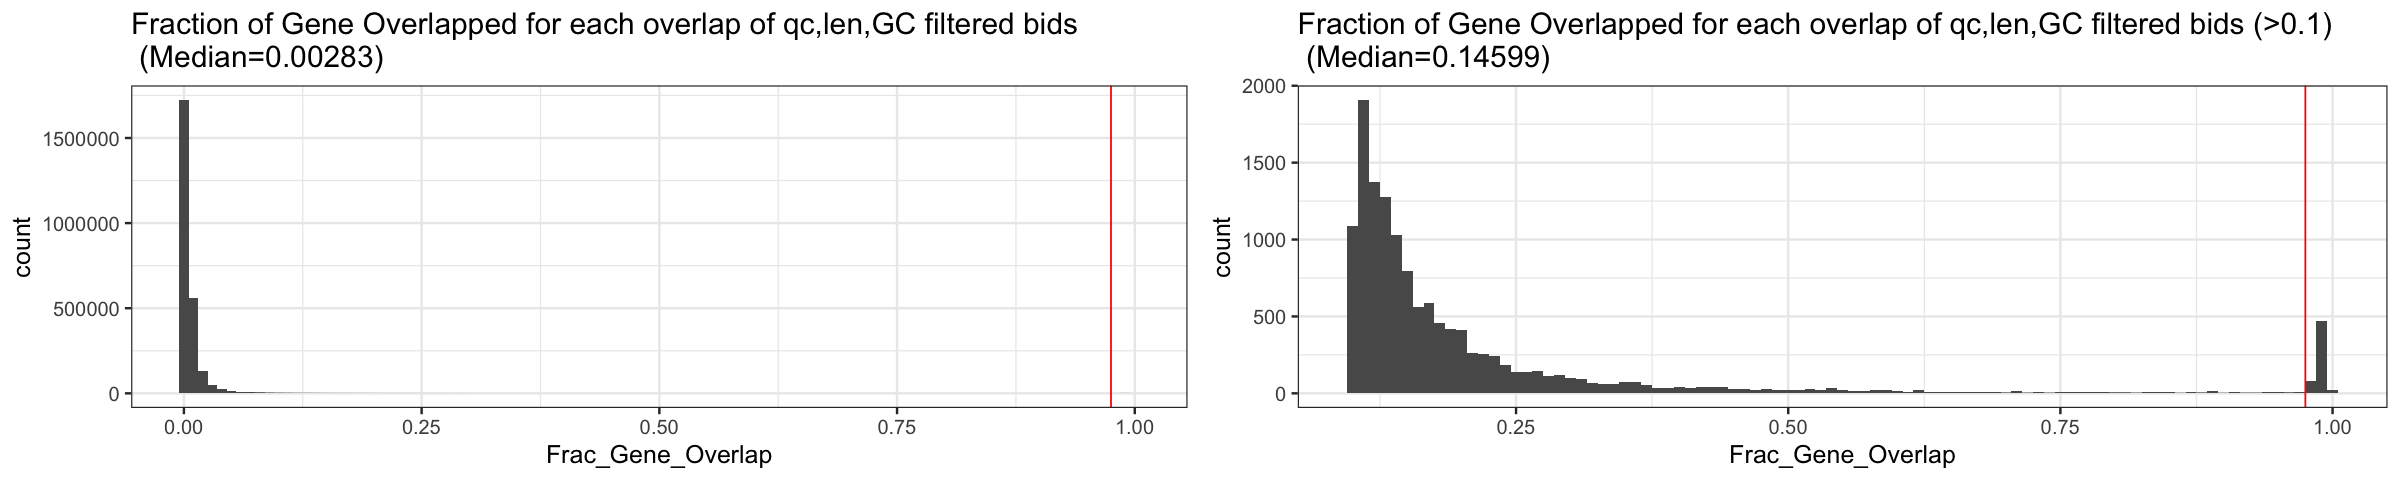

In [52]:
# graph overlaps
p1 <- ggplot(overlaps_filt, aes(x=Frac_Gene_Overlap)) + geom_histogram(binwidth=0.01) + 
ggtitle(paste0("Fraction of Gene Overlapped for each overlap of qc,len,GC filtered bids\n (Median=", 
               round(median(overlaps_filt$Frac_Gene_Overlap),5), ")")) + theme_bw(base_size=15) +
geom_vline(xintercept=0.975, color="red")
p2 <- ggplot(overlaps_filt[overlaps_filt$Frac_Gene_Overlap>0.1,], aes(x=Frac_Gene_Overlap)) + geom_histogram(binwidth=0.01) + 
ggtitle(paste0("Fraction of Gene Overlapped for each overlap of qc,len,GC filtered bids (>0.1)\n (Median=", 
               round(median(overlaps_filt[overlaps_filt$Frac_Gene_Overlap>0.1,]$Frac_Gene_Overlap),5), ")")) + 
theme_bw(base_size=15) + geom_vline(xintercept=0.975, color="red")
options(repr.plot.height = 4, repr.plot.width = 20)
plot_grid(p1, p2, nrow=1)

In [53]:
over_90_filt <- unique(overlaps_filt[overlaps_filt$Frac_Gene_Overlap > .975,]$BidID)
length(over_90_filt)

[1] 550

## 3. Filter the bidirectionals

In [54]:
# get the new filtered bidirectionals
filt_filt_bids <- all_filt_bids[!all_filt_bids$BidID %in% pos_neg_filt,]
filt_filt_bids <- filt_filt_bids[!filt_filt_bids$BidID %in% over_90_filt,]
dim(all_filt_bids)
dim(filt_filt_bids)

[1] 868657     10

[1] 848490     10

In [55]:
# create a new unique id after merging
filt_filt_bids[1:2,]

chr2,Bid_Start,Bid_Stop,Samples,Num_Samples,source_summary,source,score,Bid_Length,BidID
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>
chr1,3917,4919,"Blumberg2021characterizing,Godfrey2017mll,Ikegami2020phosphorylated,Judd2020unpublished,Li2020human,Liu2021transcription,Nilson2017oxidative,Parida2019nucleotide,Santoriello2020rna,Sathyan2019improved,Sendinc2019pcif1,Smith2021peppro,Sumida2018ultra,Wan2020h2bg53d",14,dREG Only,dREG,0,1003,chr1-3917-4919-dREG
chr1,5632,6042,"Blumberg2021characterizing,Godfrey2017mll,Ikegami2020phosphorylated,Judd2020unpublished,Li2020human,Liu2021transcription,Nilson2017oxidative,Parida2019nucleotide,Santoriello2020rna,Sathyan2019improved,Sendinc2019pcif1,Smith2021peppro,Sumida2018ultra,Wan2020h2bg53d",14,dREG Only,dREG,0,411,chr1-5632-6042-dREG


In [57]:
# save file
write.table(filt_filt_bids[,c("chr2", "Bid_Start", "Bid_Stop", "Samples","Num_Samples","source_summary", 
                             "source", "score", "Bid_Length")], 
            "hg38_master_qc_gc_len_posneg_gene_filt.bed", 
            quote=FALSE, sep="\t", row.names=FALSE, col.names=FALSE)
write.table(filt_filt_bids[,c("chr2", "Bid_Start", "Bid_Stop", "source", "BidID")], 
            "hg38_master_qc_gc_len_posneg_gene_filt_uniqueid.bed", 
            quote=FALSE, sep="\t", row.names=FALSE, col.names=FALSE)

In [58]:
print(sessionInfo())

R version 4.3.0 (2023-04-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/hopekirby/miniconda3/envs/r-kernel/lib/libopenblasp-r0.3.23.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Denver
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1     ggplot2_3.4.2     data.table_1.14.8

loaded via a namespace (and not attached):
 [1] crayon_1.5.2     vctrs_0.6.3      cli_3.6.1        rlang_1.1.1     
 [5] generics_0.1.3   jsonlite_1.8.7   labeling_0.4.2   glue_1.6.2      
 [9] colorspace_2.1-0 htmltools_0.5.5  IRdisplay_1.1    IRkernel_1.3.2  
[13] scales_1.2.1     fansi_1.0.4      grid_4.3.0       evaluate_0.21   
[17] munsell_0.5.0    tibble_3.2.1     fastmap_1.1.1    base64enc_0.1-3 
[21] lifecycle_1.0.3  compi